cuda

Wave Power:9.387872705701739e-05
Radar Power:0.0001000004995148629


100%|██████████| 10000/10000 [00:27<00:00, 362.44it/s]



LFM (with real)==============================
distance=> Mean value->355.9505615234375, 	 Variance->0.004737144336104393
delay=> Mean value->2.3730037810310023e-06, 	 Variance->2.1055260814608198e-19 	 CRLB:1.899781576947476e-19
distance MSE: 0.007181061431765556


100%|██████████| 10000/10000 [00:29<00:00, 335.61it/s]



Wave==============================
distance=> Mean value->355.95166015625, 	 Variance->8.382741611967504e-09
delay=> Mean value->2.3730115117359674e-06, 	 Variance->5.170395902127892e-26
distance MSE: 0.002327896887436509
tensor(1.8996e-19, device='cuda:0')
tensor(1.2848e-21, device='cuda:0')
tensor(18.9977, device='cuda:0')
tensor(19.9564, device='cuda:0')


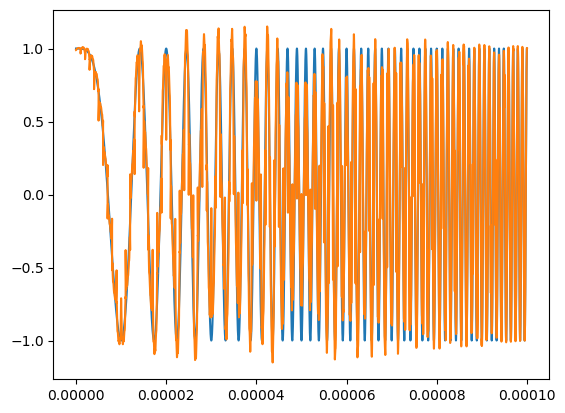

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

t = torch.linspace(0, 1e-4, int(2e5), device=device)
dt = t[1] - t[0]

# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
A = 1
MN = 10000
distance = 356
N0 = 1
comm_pulse_kind = 'OFDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
radar_pulse = myRadarPulses.LFM_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])
R = radar_pulse.repeat(K*L, 1)
G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])
c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

print()
print(f"Wave Power:{torch.sum(torch.abs(s_opt)**2)*dt}")
print(f"Radar Power:{torch.sum(torch.abs(radar_pulse)**2)*dt}")

dis, ta = myRadarPulses.montecarlo_estimation_with_real(radar_pulse, N0, distance, np.sqrt(A), 3e8, MN)
print("\nLFM (with real)" + "="*30)
print(f'distance=> Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'delay=> Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)} \t CRLB:{myRadarPulses.LFM_delayCRLB_with_real(B, T, N0, A)}')
print(f"distance MSE: {torch.mean(torch.abs(dis - distance)**2)}")

dis, ta = myRadarPulses.montecarlo_estimation_with_real(s_opt, N0, distance, np.sqrt(A), 3e8, MN)
print("\nWave" + "="*30)
print(f'distance=> Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'delay=> Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)}')
print(f"distance MSE: {torch.mean(torch.abs(dis - distance)**2)}")

Beff_1 = myRadarPulses.compute_Beff(radar_pulse)
Beff_2 = myRadarPulses.compute_Beff(s_opt)
Teff_1 = myRadarPulses.compute_Teff(radar_pulse)
Teff_2 = myRadarPulses.compute_Teff(s_opt)

print(myRadarPulses.crlb_delay(A**2 * torch.sum(torch.abs(radar_pulse)**2)*dt / N0, Beff_1) * dt)
print(myRadarPulses.crlb_delay(A**2 * torch.sum(torch.abs(s_opt)**2)*dt / N0, Beff_2) * dt)
print(myRadarPulses.crlb_doppler(A**2 * torch.sum(torch.abs(radar_pulse)**2)*dt / N0, Teff_1) * dt)
print(myRadarPulses.crlb_doppler(A**2 * torch.sum(torch.abs(s_opt)**2)*dt / N0, Teff_2) * dt)

In [ ]:
ambiguity = myRadarPulses.fast_ambiguity(radar_pulse, radar_pulse)

# Magnitude squared (normalized)
ambiguity_mag = torch.abs(ambiguity)**2
# ambiguity_mag = ambiguity_mag / torch.max(ambiguity_mag)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(ambiguity_mag.cpu().numpy(),
           aspect='auto', cmap='viridis')
plt.xlabel('Doppler Shift (kHz)')
plt.ylabel('Delay (ms)')
plt.title('Ambiguity Function of LFM Pulse (Fast Method)')
plt.colorbar(label='Normalized Magnitude')
plt.tight_layout()
plt.show()

ambiguity_mag[torch.argmax(ambiguity_mag)]